In [1]:
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from functions import make_dataset

In [3]:
from functions import make_portfolio

In [24]:
import time


In [4]:
features3 = pd.read_pickle("training_sets/features3")

In [5]:
Date3= np.load("training_sets/Date3.npy", allow_pickle = True)

In [6]:
Tickers3 = np.load("training_sets/Tickers3.npy", allow_pickle = True)

In [7]:
the_column = features3.loc[Date3[0], "return_40"].copy()

In [10]:
n_classes = 3

In [20]:
cutoffs = [np.nanpercentile(the_column, 100 - i*(100/n_classes)) for i in range(4)]

In [21]:
cutoffs[0] += 1

In [103]:
def make_class_multi(col_name, features_date_indexed, Date_array, n_classes):
    
    to_append = np.array([])
    
    for Date1 in Date_array:
        
        the_column = features_date_indexed.loc[Date1, col_name].copy()
        
        if np.sum(the_column.isna()) / len(the_column) > 0.4:
            
            to_append = np.append(to_append, [np.nan] * len(the_column))
            
        else:
            
            cutoffs = [np.nanpercentile(the_column, 100 - i*(100/n_classes)) for i in range(n_classes+1)]
            cutoffs[0] += 1
        
            def map_func(x):
                global cutoffs
                global n_classes

                for i in range(n_classes):
                    if x >= cutoffs[i+1] and x < cutoffs[i]:
                        return i
                    
            mapped = the_column.map(map_func, na_action = "ignore")
            
            to_append = np.append(to_append, mapped)
            
    return to_append

In [104]:
features3["Class_40_5"] = make_class_multi("return_40", features3, Date3, 5)

In [105]:
test_cols = np.random.choice(features3.columns[1:-3], 12, replace = False)

In [106]:
test_cols

array(['ABAND_indicator_40', 'close_0/Close_160',
       'Net Cash from Investing Activities/Cash & Cash Equivalents_QC',
       'MFI_160', 'BOL_indicator_40', 'RSI_7', 'EBITDA_YC',
       'close_240/Close_360', 'ULTOSC_28',
       'Property, Plant & Equipment, Net_YC',
       'Total Current Assets/Total Assets_QC', 'close_40/Close_320'],
      dtype=object)

In [9]:
features3.columns[-2]

'Class_binary_40_20'

In [107]:
X_train, X_test, Y_train, Y_test = make_dataset(features3, 200, 40, 500, Date3, test_cols, 'Class_40_5')

In [112]:
Y_train.astype(int)

Date        Ticker
2020-05-06  DCI       1
2020-05-13  RS        0
2020-05-19  CLGX      0
2020-04-30  AGCO      2
2019-06-17  SINT      4
                     ..
2020-02-05  STZ       4
2019-05-09  LAZ       3
2020-03-09  HURN      4
2020-02-12  EVTC      4
2020-04-14  RAVN      1
Name: Class_40_5, Length: 336892, dtype: int32

In [113]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 1,
  'objective':'multi:softprob',
  'num_class' : 5,
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [ ]:
'binary:logistic'

In [ ]:
'objective':'multi:softprob',
'num_class' : 2,

In [114]:
xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = test_cols)
xgtest = xgboost.DMatrix(X_test, feature_names = test_cols)

bst = xgboost.train(params1, xgtrain, num_boost_round = 1)


In [45]:
len(np.arange(len(X_test)))

665

In [116]:
xgtest = xgboost.DMatrix(X_test.values, feature_names = test_cols)

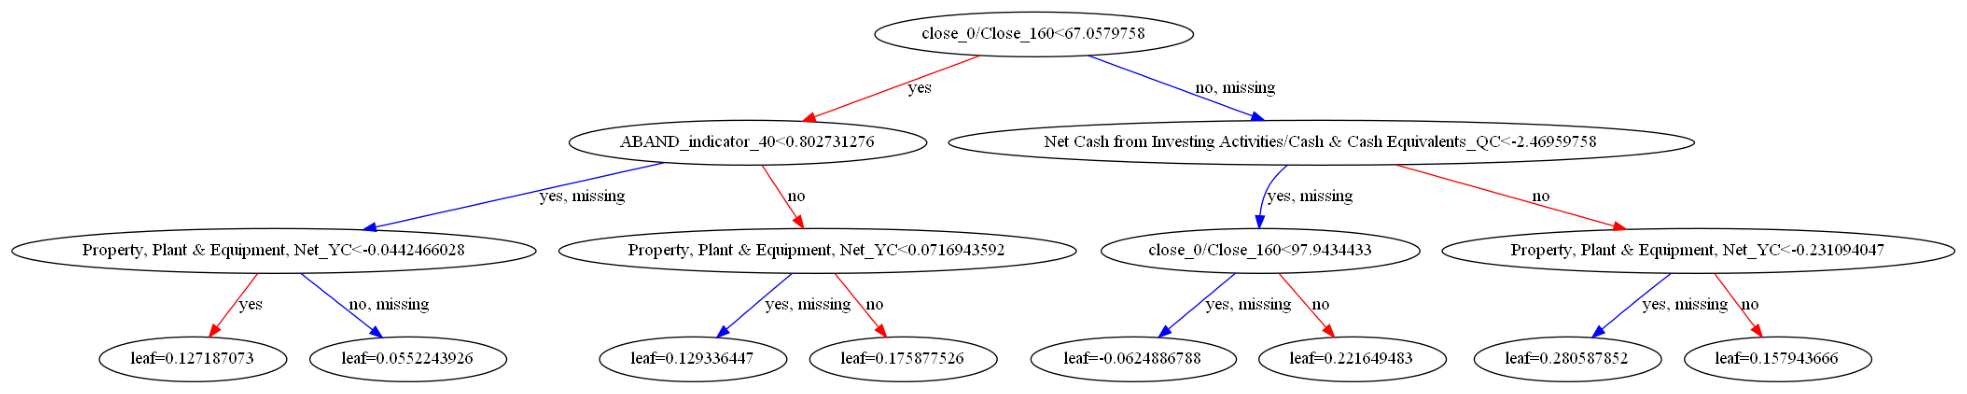

In [143]:

fig, ax = plt.subplots(figsize=(35, 10))  # whatever size you want
xgboost.plot_tree(bst, num_trees = 4, ax=ax)
plt.show()

In [136]:
X_test.iloc[0]

ABAND_indicator_40                                               -0.220694
close_0/Close_160                                                38.251438
Net Cash from Investing Activities/Cash & Cash Equivalents_QC     0.067317
MFI_160                                                          57.738584
BOL_indicator_40                                                 -0.084112
RSI_7                                                            18.504834
EBITDA_YC                                                        -0.354500
close_240/Close_360                                             -30.822747
ULTOSC_28                                                        32.192746
Property, Plant & Equipment, Net_YC                              -0.007769
Total Current Assets/Total Assets_QC                              0.004850
close_40/Close_320                                               77.340360
Name: THO, dtype: float64

In [163]:
"""
THIS IS HOW XGBOOST GETS YOU THE SOFTPROB VALS, THE SUMMED VALS ARE THE LEAF VALS FOR EACH CLASS AND THERE IS A TREE GROWN FOR EACH CLASS, 

"""

np.exp(-0.02397) / np.sum(np.exp([0.1021, -0.02397, -0.0603, -0.07921, 0.05522]))

0.1950324621546768

In [147]:
"""
for class 0
"""
a = np.exp(0.1021) / (1+np.exp(0.1021))

In [148]:
"""
for class 1
"""
b = np.exp(-0.02397) / (1+np.exp(-0.02397))

In [149]:
"""
for class 2
"""
c = np.exp(-0.0603) / (1+np.exp(-0.0603))

In [150]:
"""
for class 3
"""
d = np.exp(-0.07921) / (1+np.exp(-0.07921))

In [151]:
"""
for class 4
"""
e = np.exp(0.05522) / (1+np.exp(0.05522))

In [160]:
(np.exp(c)) / np.sum(np.exp([a, b, c, d, e]))

0.19704008940112908

In [159]:
np.sum(np.exp([a, b, c, d, e]))

8.242285216957901

In [138]:
preds[0]

array([0.22124644, 0.19503294, 0.18806483, 0.18455018, 0.21110567],
      dtype=float32)

In [117]:
preds = bst.predict(xgtest)

In [123]:
"""
FOR GETTING THE MODEL CONFIGURATION (PARAMS AND SHIT)
"""
config = bst.save_config()

In [127]:
"""
FOR GETTING MODEL IN LIST FORM
"""
model = bst.get_dump()

In [131]:
len(model)

5

In [122]:
dump_list = bst.get_booster().get_dump()
num_trees = len(dump_list)

AttributeError: 'Booster' object has no attribute 'get_booster'

In [121]:
X_test.iloc[0]

ABAND_indicator_40                                               -0.220694
close_0/Close_160                                                38.251438
Net Cash from Investing Activities/Cash & Cash Equivalents_QC     0.067317
MFI_160                                                          57.738584
BOL_indicator_40                                                 -0.084112
RSI_7                                                            18.504834
EBITDA_YC                                                        -0.354500
close_240/Close_360                                             -30.822747
ULTOSC_28                                                        32.192746
Property, Plant & Equipment, Net_YC                              -0.007769
Total Current Assets/Total Assets_QC                              0.004850
close_40/Close_320                                               77.340360
Name: THO, dtype: float64

In [118]:
preds[0]

array([0.22124644, 0.19503294, 0.18806483, 0.18455018, 0.21110567],
      dtype=float32)

In [119]:
Y_test[0]

3.0

In [74]:
np.exp(0.43177) / (1+np.exp(0.43177))

0.60629624878781

In [73]:
1/(1+ np.exp(-(0.43177)))

0.60629624878781

In [52]:
X_test.iloc[0]

Total Noncurrent Assets/Total Assets_YC                           -0.019966
Cash from (Repayment of) Debt/Total Liabilities_YC                 0.083939
Accounts & Notes Receivable/Revenue_YC                            -0.121166
Current Ratio_QC                                                   0.254440
Payables & Accruals/Cost of Revenue_YC                             0.189089
Payables & Accruals/Cost of Revenue_QC                             0.055706
ADX_1_5                                                           70.576548
close_160/Close_240                                               15.079942
Enterprise Value/Share Capital & Additional Paid-In Capital_QC     0.317714
Shares (Diluted)/Shares (Basic)                                    1.029554
Shares (Diluted)/Shares (Basic)_YC                                 0.000723
close_20/Close_120                                                33.135951
Name: TECH, dtype: float64

In [54]:
0.5 - 0.3 *0.2044

0.43868

In [29]:
make_portfolio()

<function functions.make_portfolio(portfolio_length, prob_predictions_0, X_test)>